In [19]:
from tree_partition import sample_uniform_partition_of_tree
import matplotlib.pyplot as plt
import tree_utils as tu
import networkx as nx
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

In [20]:
def make_clique(n):
    return nx.complete_graph(n)

def make_biclique(m, n):
    return nx.complete_bipartite_graph(m, n)

def num_trees_clique(n):
    return n ** (n-2)

def num_snappables_clique(n):
    assert n % 2 == 0
    combo = math.comb(n, int(n/2))
    return combo * (2 / (2 ** n)) * (n ** (n - 2))

def fraction_snappables_clique(n):
    return num_snappables_clique(n) / num_trees_clique(n)

def num_trees_biclique(m, n):
    return (m ** (n - 1)) * (n ** (m - 1))

def num_snappables_equal_biclique(n):
    num_edges = (n ** 2) - (2 * n) + 2
    result = 0
    for k in range(1, n): # 1 to n - 1, inclusive
        combo = math.comb(n, k) ** 2
        num_pairs_trees = ((k ** (n - k - 1)) * ((n - k) ** (k - 1))) ** 2
        result += (combo * num_pairs_trees)
    return 0.5 * num_edges * result

def fraction_snappables_equal_biclique(n):
    return num_snappables_equal_biclique(n) / num_trees_biclique(n, n)

In [21]:
def count_snaps(graph, trials):
    num_snaps = 0
    for _ in tqdm(range(trials)):
        tree = tu.uniform_random_spanning_tree(graph)
        for node in tree.nodes:
            tree.nodes[node]['pop'] = 1
        part_size = len(tree) / 2
        _, num_balance_edges = sample_uniform_partition_of_tree(tree, 2, part_size, part_size, "pop")
        if num_balance_edges:
            num_snaps += 1
    return num_snaps / trials

In [96]:
N = 4
num_trials = 100000
graph = make_biclique(N, N)

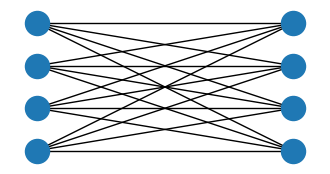

In [97]:
fig, ax = plt.subplots(figsize=(4,2))
left_set, right_set = nx.bipartite.sets(graph)

nx.draw(graph, pos=nx.bipartite_layout(graph, left_set), ax=ax)

In [98]:
proportion = count_snaps(graph, num_trials)

100%|█████████████████████████████████| 100000/100000 [00:19<00:00, 5194.45it/s]


In [99]:
proportion

0.60085

In [100]:
fraction_snappables_equal_biclique(N)

0.7421875

In [101]:
# the above fractions should be basically equal!!! see the clique example below which is equal...

In [102]:
N = 8
num_trials = 100000
graph = make_clique(N)

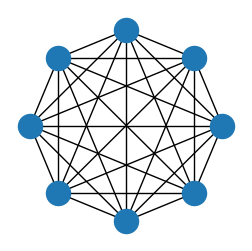

In [107]:
fig, ax = plt.subplots(figsize=(3,3))
nx.draw_circular(graph, ax=ax)

In [108]:
proportion = count_snaps(graph, num_trials)

100%|█████████████████████████████████| 100000/100000 [00:18<00:00, 5279.66it/s]


In [109]:
proportion

0.55022

In [110]:
fraction_snappables_clique(N)

0.546875